In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from keras.models import Model
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import os
from tqdm import tqdm

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [5]:
# Load tabular data
df_orig=pd.read_csv('/kaggle/input/cdcproject/train.csv')
print(f"Original Dataset shape: {df_orig.shape}")
df_pros=df=pd.read_csv('/kaggle/input/cdcproject/new_train.csv')
print(f"Processed Dataset shape: {df_pros.shape}")


Original Dataset shape: (16209, 21)
Processed Dataset shape: (16209, 37)


In [6]:
# Define features and target
exclude_cols = ['id', 'price', 'date']
feature_cols_orig = [col for col in df_orig.columns if col not in exclude_cols]
feature_cols_pros = [col for col in df_pros.columns if col not in exclude_cols]
X_orig = df_orig[feature_cols_orig].values
X_pros = df_pros[feature_cols_pros].values
y = df['price'].values
ids = df['id'].values
print(f"Features in X_orig: {len(feature_cols_orig)}")
print(f"Features in X_pros: {len(feature_cols_pros)}")
print(f"Samples: {len(X_orig)}")

Features in X_orig: 18
Features in X_pros: 34
Samples: 16209


In [7]:
# Split data
X_train_orig, X_test_orig, y_train_orig, y_test_orig, ids_train_orig, ids_test_orig = train_test_split(X_orig, y, ids, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train_pros, X_test_pros, y_train_pros, y_test_pros, ids_train_pros, ids_test_pros = train_test_split(X_pros, y, ids, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [8]:
# Scale features
scaler_orig = StandardScaler()
scaler_pros = StandardScaler()
X_train_scaled_orig = scaler_orig.fit_transform(X_train_orig)
X_test_scaled_orig = scaler_orig.transform(X_test_orig)
X_train_scaled_pros = scaler_pros.fit_transform(X_train_pros)
X_test_scaled_pros = scaler_pros.transform(X_test_pros)

In [9]:
# Model 1: Xgboost (Tabular data only)
xgb_model_orig = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_model_pros = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_model_orig.fit(X_train_scaled_orig, y_train_orig)
xgb_model_pros.fit(X_train_scaled_pros, y_train_pros)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [10]:
y_pred_xgb_orig = xgb_model_orig.predict(X_test_scaled_orig)
y_pred_xgb_pros = xgb_model_pros.predict(X_test_scaled_pros)
xgb_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_xgb_orig))
xgb_r2_orig = r2_score(y_test_orig, y_pred_xgb_orig)
xgb_rmse_pros = np.sqrt(mean_squared_error(y_test_pros, y_pred_xgb_pros))
xgb_r2_pros = r2_score(y_test_pros, y_pred_xgb_pros)


print(f"\nXGBoost Results (Original Tabular Data):")
print(f"Test RMSE: ${xgb_rmse_orig:,.2f}")
print(f"Test R²: {xgb_r2_orig:.4f}")

print(f"\nXGBoost Results (Processed Tabular Data):")
print(f"Test RMSE: ${xgb_rmse_pros:,.2f}")
print(f"Test R²: {xgb_r2_pros:.4f}")


XGBoost Results (Original Tabular Data):
Test RMSE: $115,820.13
Test R²: 0.8931

XGBoost Results (Processed Tabular Data):
Test RMSE: $26,131.30
Test R²: 0.9946


In [11]:
# Load Images
def load_images(ids, img_dir='/kaggle/input/cdcproject/train_img/train_img', img_size=IMG_SIZE):
    images = []
    for house_id in tqdm(ids, desc="Loading"):
        img_path = os.path.join(img_dir, f"{house_id}.png")
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        images.append(img)

    return np.array(images, dtype=np.float32)

In [12]:
def multimodal_generator(ids, X_tab, y, batch_size):
    IMG_DIR = '/kaggle/input/cdcproject/train_img/train_img'
    while True:
        for i in range(0, len(ids), batch_size):
            batch_ids = ids[i:i+batch_size]
            batch_tab = X_tab[i:i+batch_size]
            batch_y = y[i:i+batch_size]

            batch_imgs = []
            for hid in batch_ids:
                path = os.path.join(IMG_DIR, f"{hid}.png")
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                batch_imgs.append(img)

            yield (np.array(batch_imgs, dtype=np.float32), batch_tab), batch_y


In [13]:
# Model 2: CNN Hybrid (Tabular Data + Images)

# Image branch with ResNet50
img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=img_input)
base_model.trainable = False
x_img = base_model.output
x_img = GlobalAveragePooling2D()(x_img)
x_img = Dense(256, activation="relu")(x_img)
x_img = Dropout(0.3)(x_img)
x_img = Dense(128, activation="relu")(x_img)

# Tabular branch (Processed)
tab_pros_input = Input(shape=(X_train_scaled_pros.shape[1],),name="tabular_processed")
x_tab_pros = Dense(128, activation="relu")(tab_pros_input)
x_tab_pros = BatchNormalization()(x_tab_pros)
x_tab_pros = Dropout(0.3)(x_tab_pros)
x_tab_pros = Dense(64, activation="relu")(x_tab_pros)

I0000 00:00:1767758718.679052      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# Merge
merged_pros = Concatenate()([x_img, x_tab_pros])
x_merge_pros = Dense(128, activation="relu")(merged_pros)
x_merge_pros = Dropout(0.3)(x_merge_pros)
x_merge_pros = Dense(64, activation="relu")(x_merge_pros)
output_pros = Dense(1, activation="linear", name="price")(x_merge_pros)

# Model Making
cnn_model_pros = Model(inputs=[img_input, tab_pros_input], outputs=output_pros)

cnn_model_pros.compile(optimizer=Adam(learning_rate=0.001),loss='mse',metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

print(f"\nTotal parameters (Processed Tabular Data + Images): {cnn_model_pros.count_params():,}")



Total parameters (Processed Tabular Data + Images): 24,191,425


In [15]:
callbacks = [EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-7,verbose=1)]

In [16]:
history = cnn_model_pros.fit(
    multimodal_generator(ids_train_pros, X_train_scaled_pros, y_train_pros, BATCH_SIZE),
    steps_per_epoch=len(ids_train_pros)//BATCH_SIZE,

    validation_data=multimodal_generator(ids_test_pros, X_test_scaled_pros, y_test_pros, BATCH_SIZE),
    validation_steps=len(ids_test_pros)//BATCH_SIZE,

    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


I0000 00:00:1767758841.034478     102 service.cc:152] XLA service 0x7aa838014e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767758841.034524     102 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767758843.076429     102 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/810 ━━━━━━━━━━━━━━━━━━━━ 3:14:10 14s/step - loss: 561799692288.0000 - rmse: 749532.9375

I0000 00:00:1767758848.018151     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


810/810 ━━━━━━━━━━━━━━━━━━━━ 324s 383ms/step - loss: 198190661632.0000 - rmse: 433329.2500 - val_loss: 7061373440.0000 - val_rmse: 84031.9766 - learning_rate: 0.0010
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 128s 152ms/step - loss: 32826804224.0000 - rmse: 180560.5312 - val_loss: 4305766400.0000 - val_rmse: 65618.3359 - learning_rate: 0.0010
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 120s 148ms/step - loss: 29197613056.0000 - rmse: 170311.7656 - val_loss: 3943860224.0000 - val_rmse: 62800.1602 - learning_rate: 0.0010
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 123s 153ms/step - loss: 27338780672.0000 - rmse: 164883.0625 - val_loss: 3670649600.0000 - val_rmse: 60585.8867 - learning_rate: 0.0010
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 121s 149ms/step - loss: 25904132096.0000 - rmse: 160364.3594 - val_loss: 5303869952.0000 - val_rmse: 72827.6719 - learning_rate: 0.0010
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 119s 147ms/step - loss: 25499904000.0000 - rmse: 159146.2812 - val_loss: 5075126784.0000 -

In [17]:
test_gen_pros = multimodal_generator(ids_test_pros, X_test_scaled_pros, y_test_pros,BATCH_SIZE)

steps_test_pros = len(ids_test_pros) // BATCH_SIZE

y_pred_cnn_pros = cnn_model_pros.predict(test_gen_pros,steps=steps_test_pros,verbose=1).flatten()

y_true_pros = y_test_pros[:len(y_pred_cnn_pros)]

cnn_rmse_pros = np.sqrt(mean_squared_error(y_true_pros, y_pred_cnn_pros))
cnn_r2_pros = r2_score(y_true_pros, y_pred_cnn_pros)

print(f"\nHybrid Results (Processed Tabular Data + Images):")
print(f"  Test RMSE: ${cnn_rmse_pros:,.2f}")
print(f"  Test R²: {cnn_r2_pros:.4f}")

202/202 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step

Hybrid Results (Processed Tabular Data + Images):
  Test RMSE: $60,985.60
  Test R²: 0.9704


Loading: 100%|██████████| 3242/3242 [00:26<00:00, 122.92it/s]


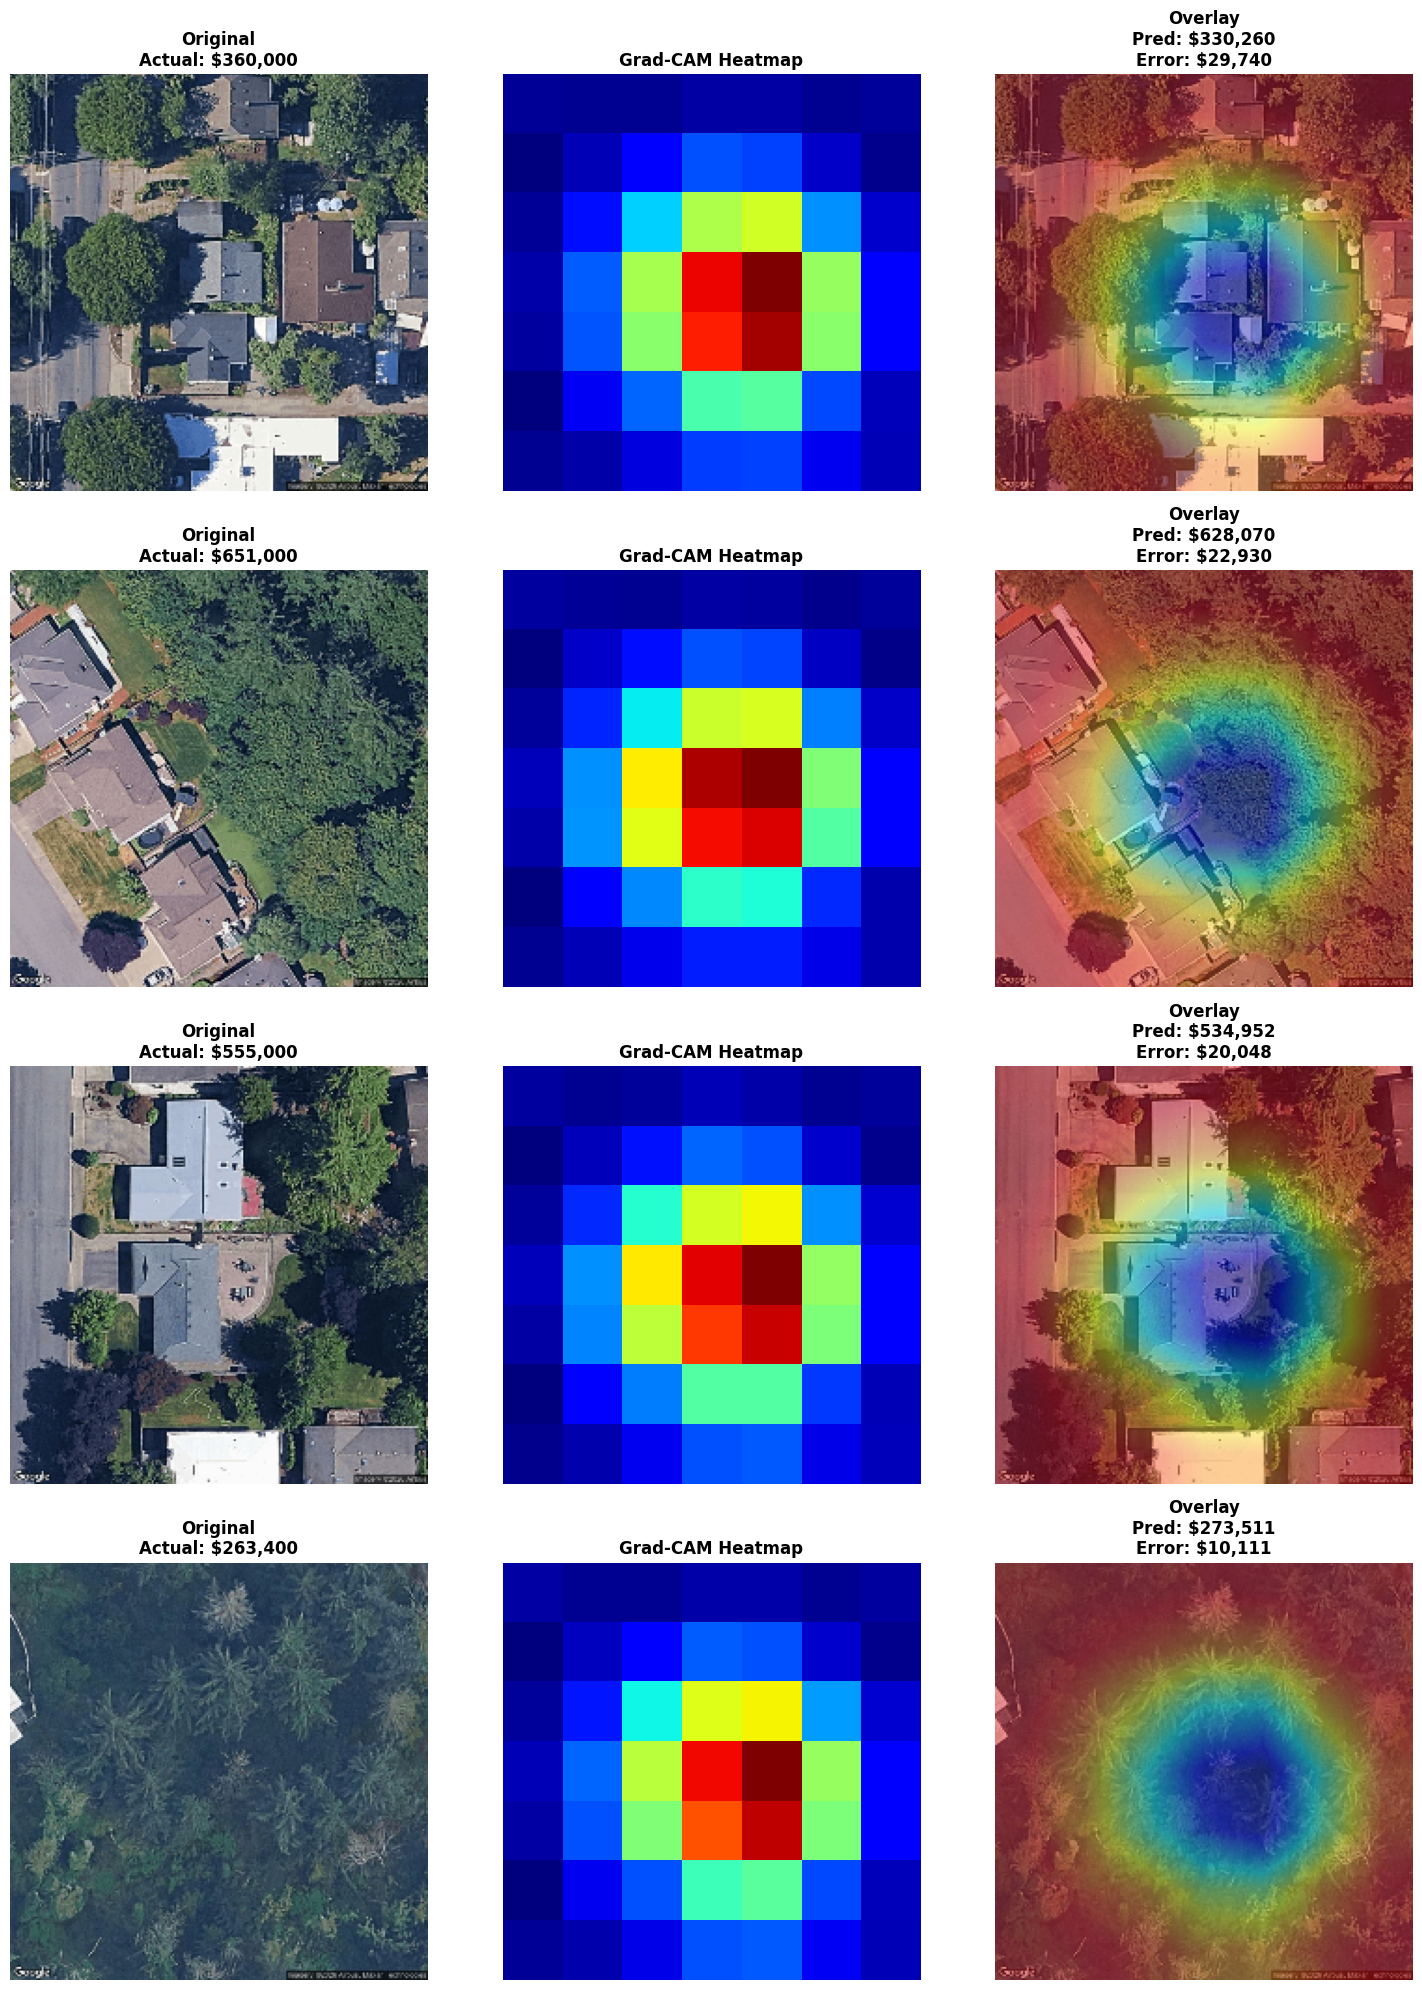

In [19]:
# Grad-Cam Visualisation
imgs_test= load_images(ids_test_pros, img_size=IMG_SIZE)
def make_gradcam_heatmap(model, img_array, tab_array, last_conv_layer_name='conv5_block3_out'):

    grad_model = Model(inputs=model.inputs,outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array, tab_array])
        loss = predictions[:, 0]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    if img.max() <= 1:
        img = np.uint8(255 * img)
    
    return cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

# Generate Grad-CAM for 4 samples
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

for i in range(4):
    idx = np.random.randint(len(imgs_test))
    img = imgs_test[idx:idx+1]
    tab = X_test_scaled_pros[idx:idx+1]
    
    pred = cnn_model_pros.predict([img, tab], verbose=0)[0][0]
    actual = y_test_pros[idx]
    
    heatmap = make_gradcam_heatmap(cnn_model_pros, img, tab)
    
    axes[i, 0].imshow(img[0])
    axes[i, 0].set_title(f'Original\nActual: ${actual:,.0f}', fontweight='bold')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(heatmap, cmap='jet')
    axes[i, 1].set_title('Grad-CAM Heatmap', fontweight='bold')
    axes[i, 1].axis('off')
    
    overlayed = overlay_heatmap(img[0], heatmap)
    axes[i, 2].imshow(overlayed)
    axes[i, 2].set_title(f'Overlay\nPred: ${pred:,.0f}\nError: ${abs(pred-actual):,.0f}', fontweight='bold')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

     Model         RMSE       R²
   XGBoost 26131.296791 0.994559
CNN Hybrid 60985.598825 0.970389
Best Model (RMSE): XGBoost
Best Model (R²): XGBoost


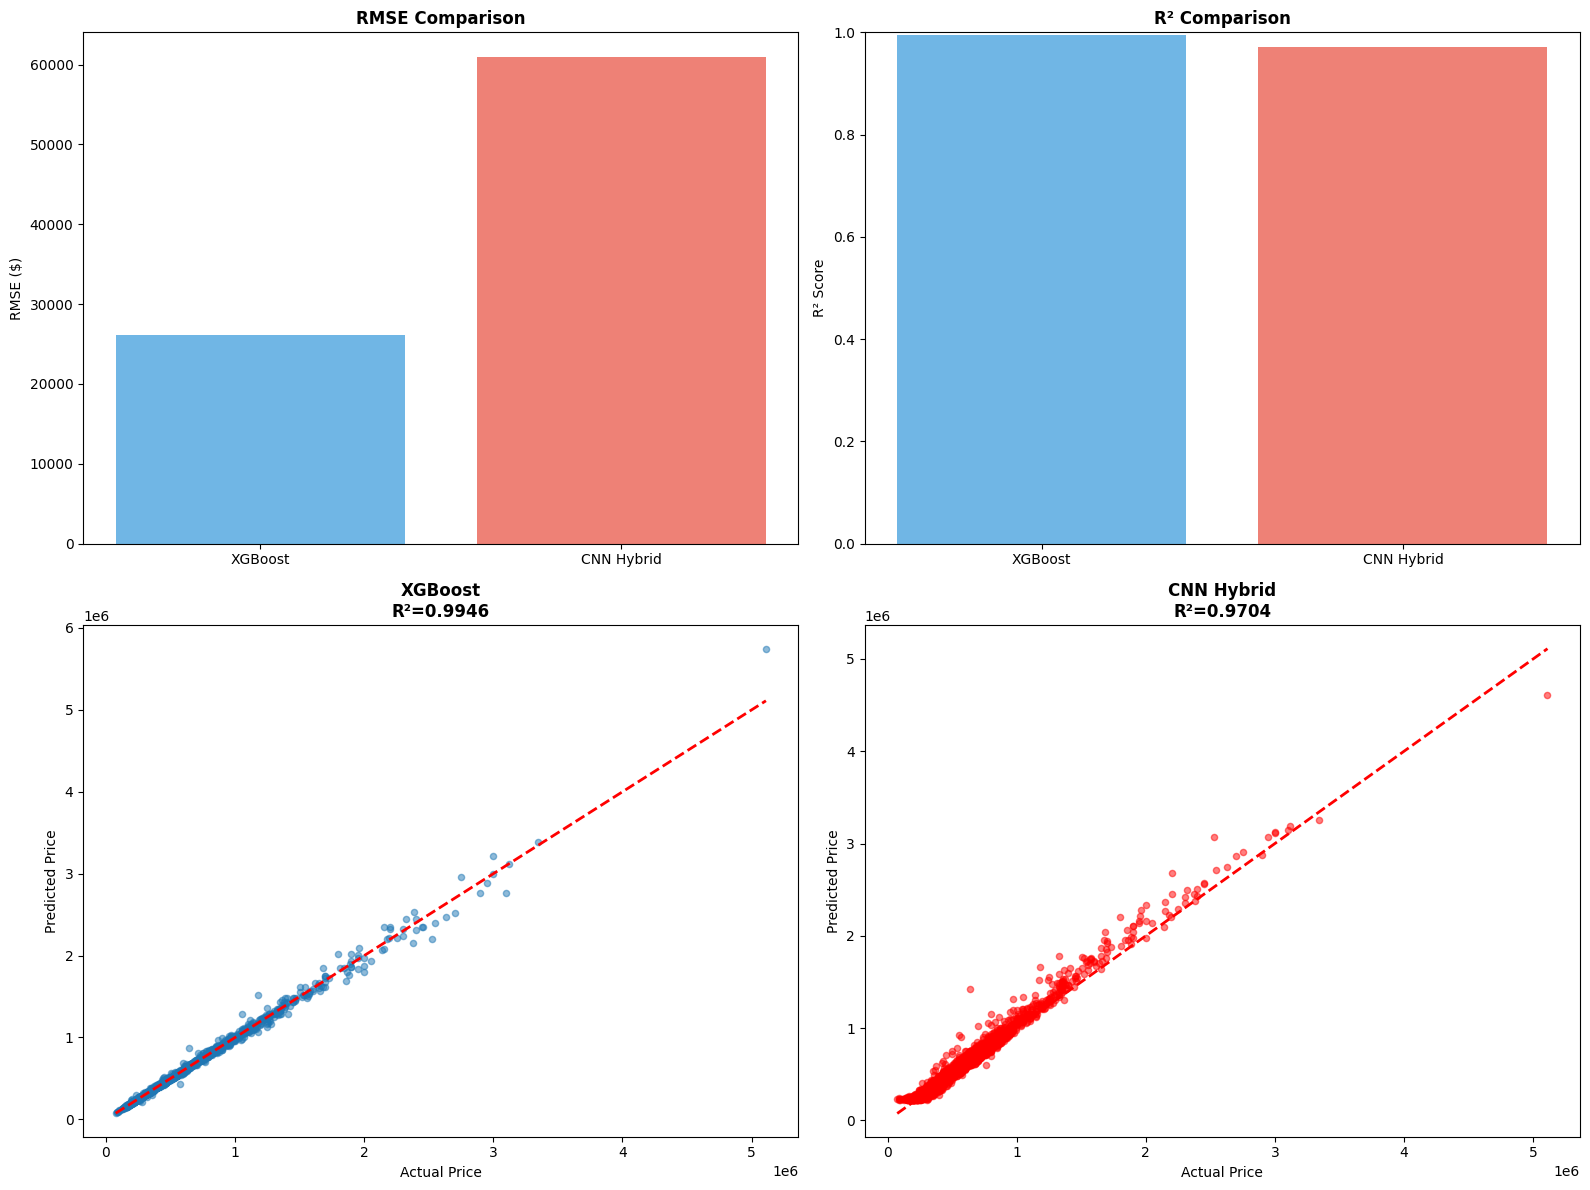

In [21]:
# Model Comparison
comparison = pd.DataFrame({
    'Model': ['XGBoost', 'CNN Hybrid'],
    'RMSE': [xgb_rmse_pros, cnn_rmse_pros],
    'R²': [xgb_r2_pros, cnn_r2_pros]
})

print(comparison.to_string(index=False))
print(f"Best Model (RMSE): {comparison.loc[comparison['RMSE'].idxmin(), 'Model']}")
print(f"Best Model (R²): {comparison.loc[comparison['R²'].idxmax(), 'Model']}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Metrics comparison
x = np.arange(2)
width = 0.35

axes[0, 0].bar(x, comparison['RMSE'], color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(comparison['Model'])
axes[0, 0].set_title('RMSE Comparison', fontweight='bold')
axes[0, 0].set_ylabel('RMSE ($)')

axes[0, 1].bar(x, comparison['R²'], color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(comparison['Model'])
axes[0, 1].set_title('R² Comparison', fontweight='bold')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_ylim([0, 1])

# Predictions vs Actual
axes[1, 0].scatter(y_test_pros, y_pred_xgb_pros, alpha=0.5, s=20)
axes[1, 0].plot([y_test_pros.min(), y_test_pros.max()], [y_test_pros.min(), y_test_pros.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Price')
axes[1, 0].set_ylabel('Predicted Price')
axes[1, 0].set_title(f'XGBoost\nR²={xgb_r2_pros:.4f}', fontweight='bold')

axes[1, 1].scatter(y_true_pros, y_pred_cnn_pros, alpha=0.5, s=20, color='red')
axes[1, 1].plot([y_test_pros.min(), y_test_pros.max()], [y_test_pros.min(), y_test_pros.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Price')
axes[1, 1].set_ylabel('Predicted Price')
axes[1, 1].set_title(f'CNN Hybrid\nR²={cnn_r2_pros:.4f}', fontweight='bold')

plt.tight_layout()
plt.show()

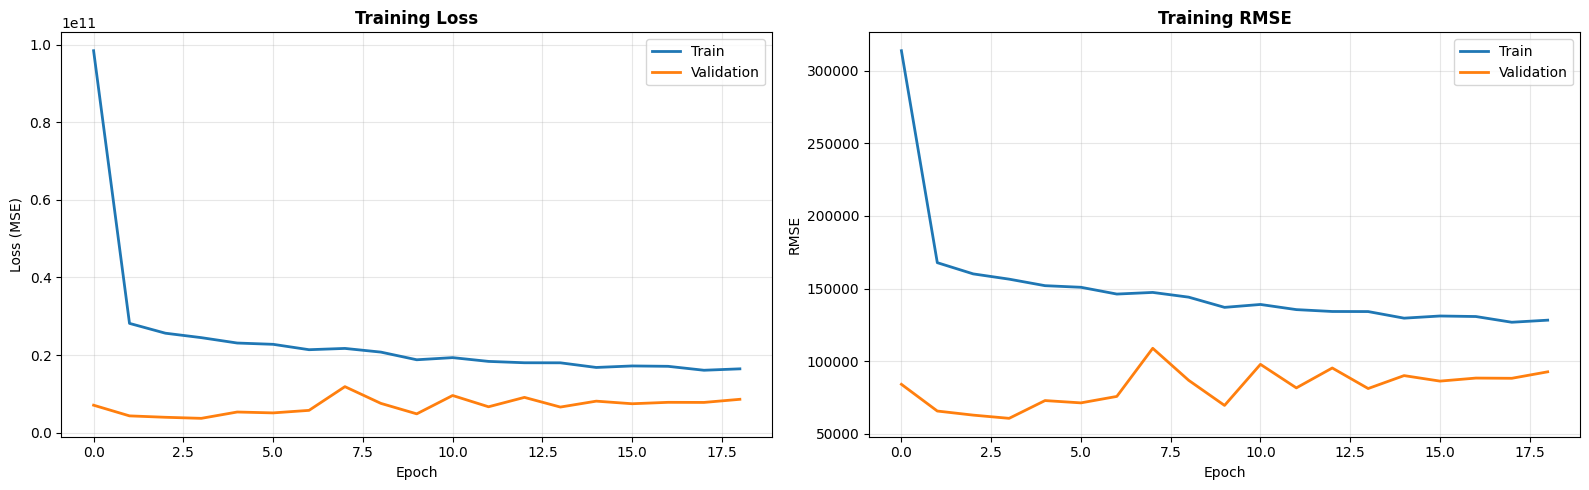

In [22]:
# Training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['rmse'], label='Train', linewidth=2)
axes[1].plot(history.history['val_rmse'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Training RMSE', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

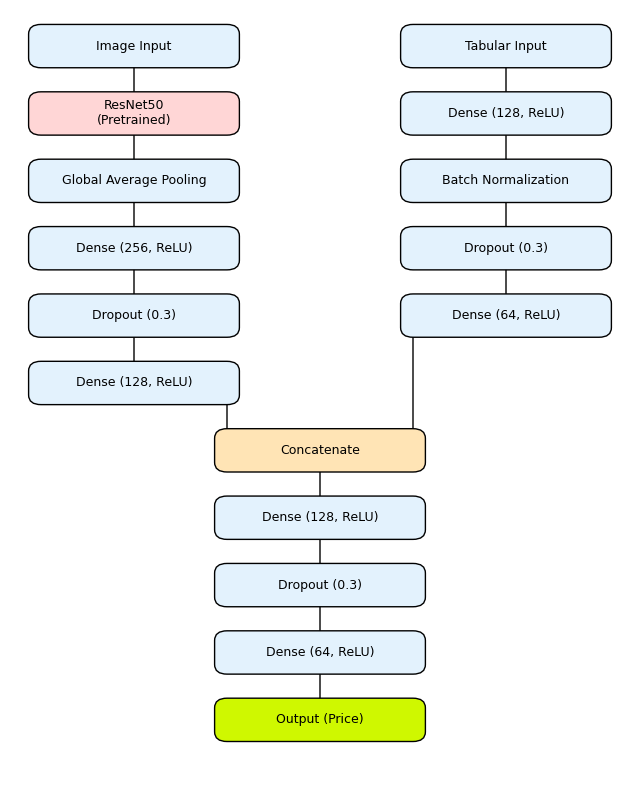

In [144]:
# Visualisation of neural network architecture
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis("off")

def box(x, y, w, h, text, fc="#E3F2FD"):
    ax.add_patch(FancyBboxPatch(
        (x, y), w, h, boxstyle="round,pad=0.02",
        ec="black", fc=fc, zorder=2))
    ax.text(x+w/2, y+h/2, text, ha="center", va="center", fontsize=9, zorder=3)

def arrow(x1, y1, x2, y2):
    ax.add_patch(FancyArrowPatch((x1, y1), (x2, y2), arrowstyle="->", zorder=1))
    
ax.set_xlim(0, 1)
ax.set_ylim(-0.6, 1)

x_img=0.05
y=0.90
dy=0.07
x_tab=0.65

box(x_img, y, 0.3, 0.05, "Image Input")
box(x_img, y-2*dy, 0.3, 0.05, "ResNet50\n(Pretrained)", "#FFD6D6")
box(x_img, y-4*dy, 0.3, 0.05, "Global Average Pooling")
box(x_img, y-6*dy, 0.3, 0.05, "Dense (256, ReLU)")
box(x_img, y-8*dy, 0.3, 0.05, "Dropout (0.3)")
box(x_img, y-10*dy, 0.3, 0.05, "Dense (128, ReLU)")

arrow(0.20, y-(0*dy), 0.20, y-(1.3*dy))
arrow(0.20, y-(2*dy), 0.20, y-(3.3*dy))
arrow(0.20, y-(4*dy), 0.20, y-(5.3*dy))
arrow(0.20, y-(6*dy), 0.20, y-(7.3*dy))
arrow(0.20, y-(8*dy), 0.20, y-(9.3*dy))

box(x_tab, y, 0.3, 0.05, "Tabular Input")
box(x_tab, y-2*dy, 0.3, 0.05, "Dense (128, ReLU)")
box(x_tab, y-4*dy, 0.3, 0.05, "Batch Normalization")
box(x_tab, y-6*dy, 0.3, 0.05, "Dropout (0.3)")
box(x_tab, y-8*dy, 0.3, 0.05, "Dense (64, ReLU)")

arrow(0.80, y-(0*dy), 0.80, y-(1.3*dy))
arrow(0.80, y-(2*dy), 0.80, y-(3.3*dy))
arrow(0.80, y-(4*dy), 0.80, y-(5.3*dy))
arrow(0.80, y-(6*dy), 0.80, y-(7.3*dy))

box(0.35, y-12*dy, 0.30, 0.05, "Concatenate", "#FFE4B5")

box(0.35, y-14*dy, 0.30, 0.05, "Dense (128, ReLU)")
box(0.35, y-16*dy, 0.30, 0.05, "Dropout (0.3)")
box(0.35, y-18*dy, 0.30, 0.05, "Dense (64, ReLU)")
box(0.35, y-20*dy, 0.30, 0.05, "Output (Price)", "#CFF800")

arrow(0.35, y-(10*dy), 0.35, y-(11.3*dy))
arrow(0.65, y-(8*dy), 0.65, y-(11.3*dy))

arrow(0.50, y-12*dy, 0.50, y-(13.3*dy))
arrow(0.50, y-14*dy, 0.50, y-(15.3*dy))
arrow(0.50, y-16*dy, 0.50, y-(17.3*dy))
arrow(0.50, y-18*dy, 0.50, y-(19.3*dy))

plt.show()